In [158]:
import pandas as pd
import numpy as np
import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
import xgboost as XGB
from lightgbm import LGBMRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization

In [7]:
#path = '../data/generated/df_newimages_bands_downside.pkl.z'
path = '../data/generated/df_newimages_bands_downside_low_var_filter.pkl.z'
df = jb.load(path)
df['ndwi51'] =  df[['b5', 'b1']].apply(lambda x: pixel_ndwi(x.b5, x.b1), axis=1)
df.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,b2b4,b3b4,ndwi15,ndwi24,ndwi53,cspmb7,ndwi51
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,1.162614,1.094573,0.419775,0.302256,-0.152982,23.382784,-0.419775
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.0490,0.0316,0.0283,0.0237,1.171434,1.099318,0.419775,0.316380,-0.153713,23.382784,-0.419775
2,233,1132,3.299687,0.1199,0.0879,0.0666,0.0461,0.0488,0.0324,0.0281,0.0238,1.168473,1.096035,0.421458,0.311940,-0.154246,23.158824,-0.421458
3,233,1133,3.268182,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,1.175411,1.111754,0.421458,0.322339,-0.172881,23.158824,-0.421458
4,233,1134,3.278125,0.1196,0.0884,0.0677,0.0454,0.0489,0.0323,0.0285,0.0238,1.174645,1.104724,0.419585,0.321375,-0.161235,23.607309,-0.419585


In [8]:
image = np.zeros((df.y.max()+1, df.x.max()+1))

In [9]:
image.shape

(1639, 2297)

In [10]:
for i, row in enumerate(df.itertuples()):
    x = row.x
    y = row.y
    z = row.z
    image[y][x] = z

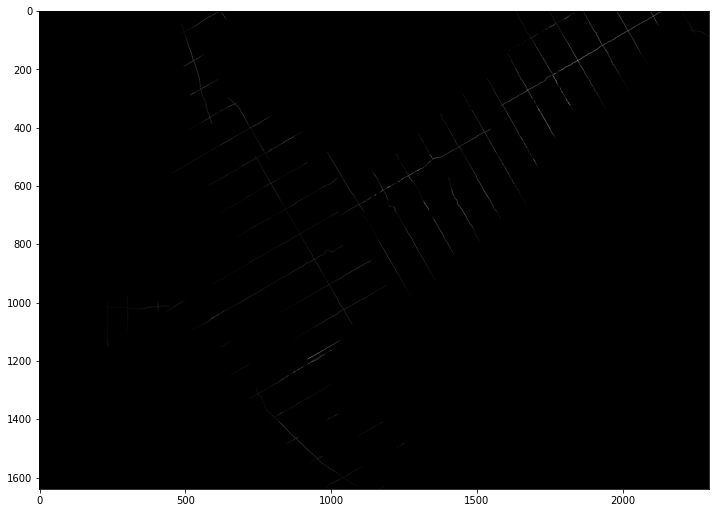

In [11]:
plt.figure(figsize=(12,10))
plt.imshow(image, 'gray')

In [12]:
kernel = np.ones((50,50))

In [13]:
def train_test_window_dataset(image, kernel, df, features_columns, train_window_size=1):
    """
    Apply rolling window defined by kernel on bathymetry image and extract
    train and validation data from pixel position concatenating with dataframe features_columns data
    train_window_size controls how many windows will be applied for extract train data
    e.g:
    train_window_size = 2
    2 kernel size for train
    1 kernel size for val
    the proportion is always 1 val for N train_window_size
    """
    output_train_data = [] # list of dict with data
    output_val_data = [] # list of dict with data
    y_start = 0
    y_end = kernel.shape[0]
    x_end = image.shape[1]
    train_controller = True
    val_controller = False
    
    train_window_counter = 0
    
    while True:
        for row in range(y_start, y_end):
            for column in range(x_end):
                px = column
                py = row
                z = image[py][px]
                if z != 0:
                    df_row = df[(df.x == px) & (df.y == py)]
                    aux_dict = {
                        'index': df_row.index[0],
                        'z': z,
                        'x': px,
                        'y': py,
                    }
                    if train_controller:
                        output_train_data.append(aux_dict)
                    if val_controller:
                        output_val_data.append(aux_dict)
        
        y_start = y_end
        y_end = y_end + kernel.shape[0]
        
        if (train_window_counter == train_window_size) and train_controller:
            # Reverse if on max
            train_controller = not train_controller
            val_controller = not val_controller
            train_window_counter = 0
        elif not train_controller:
            train_controller = not train_controller
            val_controller = not val_controller
        else:
            train_window_counter += 1
        

        if y_end > image.shape[0] and y_end != y_start:
            y_end = image.shape[0]

        if y_start > image.shape[0] or y_end == y_start:
            break

    train_df = pd.DataFrame(output_train_data).set_index('index')
    val_df = val_df = pd.DataFrame(output_val_data).set_index('index')
    
    output_train_df = df[df.index.isin(train_df.index)][features_columns]
    output_val_df = df[df.index.isin(val_df.index)][features_columns]
    
    # Return train and val dataframe with same index as the input dataframe and with selected features
    return output_train_df, output_val_df

In [14]:
features_columns = list(df.columns)
train_df, val_df = train_test_window_dataset(image, kernel, df, features_columns=features_columns, train_window_size=1)

In [17]:
len(train_df), len(val_df)

(12079, 6176)

In [18]:
len(train_df) + len(val_df)

18255

In [19]:
import cv2

rgb_image = cv2.imread('../data/generated/rgb_image.jpg')
#image = rgb_image.copy()
for i, row in enumerate(train_df.itertuples()):
    x = int(row.x)
    y = int(row.y)
    rgb_image = cv2.circle(rgb_image ,(x,y),1,[255,0,0],1)
cv2.imwrite('generated/train_data.jpg', rgb_image)

True

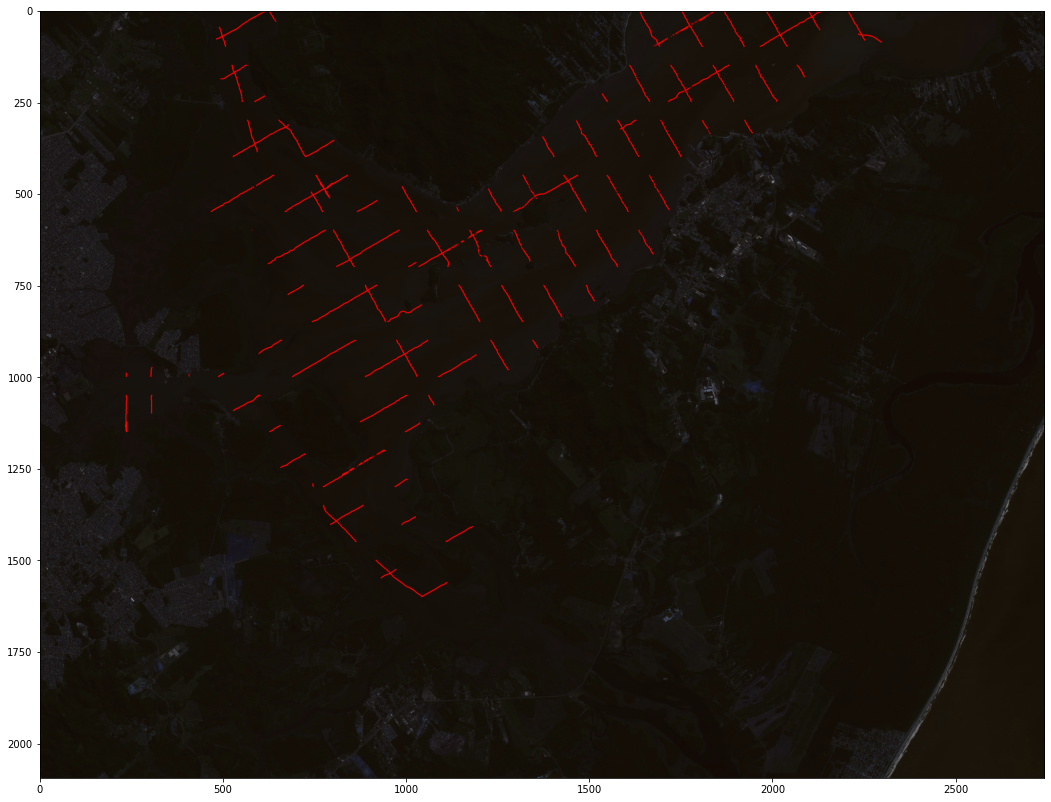

In [20]:
plt.figure(figsize=(18, 15))
plt.imshow(rgb_image)

In [21]:
import cv2

rgb_image = cv2.imread('../data/generated/rgb_image.jpg')
#image = rgb_image.copy()
for i, row in enumerate(val_df.itertuples()):
    x = int(row.x)
    y = int(row.y)
    rgb_image = cv2.circle(rgb_image ,(x,y),1,[255,0,0],1)
cv2.imwrite('generated/val_data.jpg', rgb_image)

True

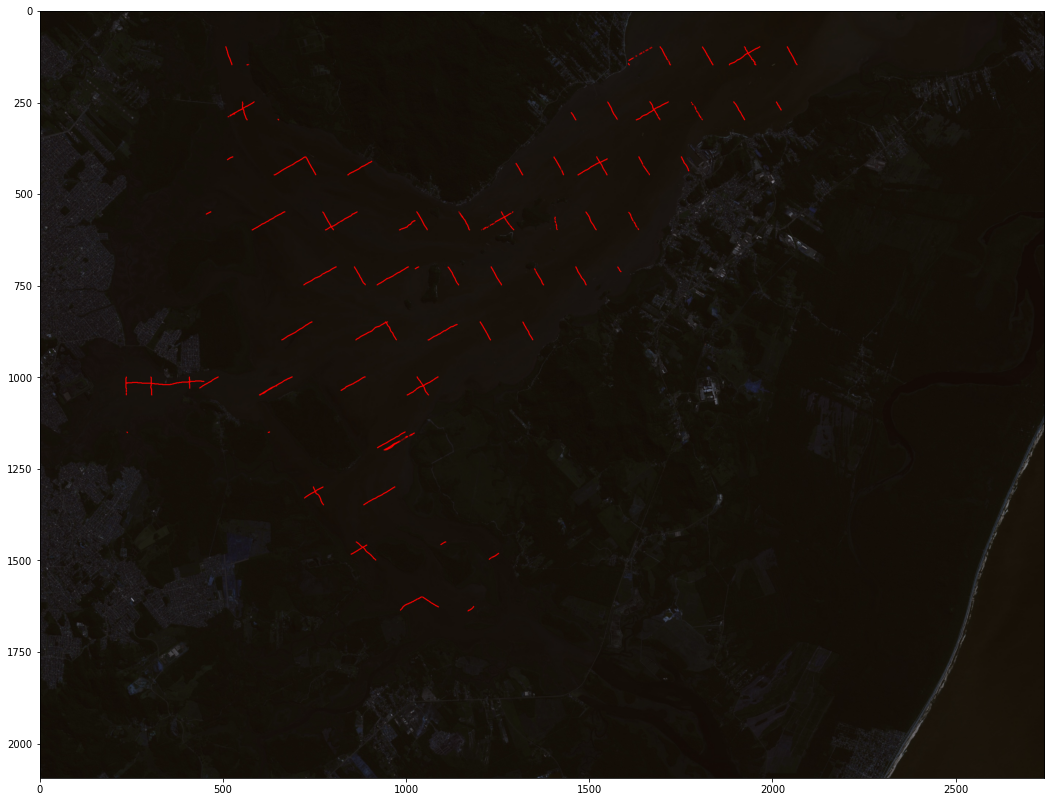

In [22]:
plt.figure(figsize=(18, 15))
plt.imshow(rgb_image)

In [24]:
# Dump raw data
jb.dump(train_df, './generated/train_window_split_RAW.pkl.z')
jb.dump(train_df, './generated/val_window_split_RAW.pkl.z')

['./generated/val_window_split_RAW.pkl.z']

In [61]:
train = train_df.copy()
val = val_df.copy()

<AxesSubplot:ylabel='z'>

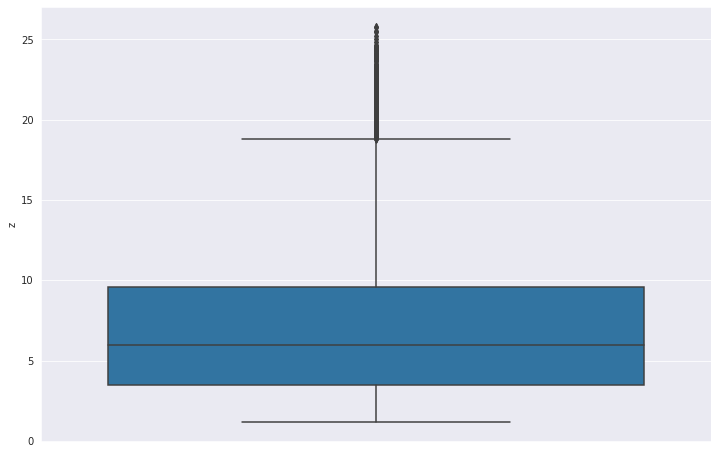

In [62]:
plt.figure(figsize=(12, 8))
sns.boxplot(y=train.z)

<AxesSubplot:ylabel='z'>

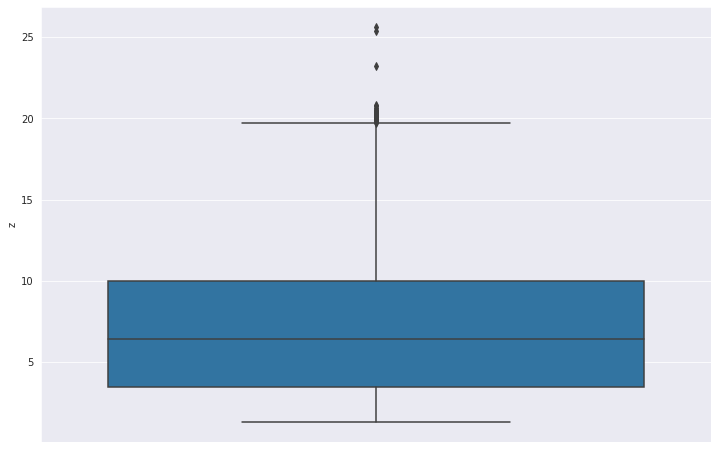

In [63]:
plt.figure(figsize=(12, 8))
sns.boxplot(y=val.z)

In [64]:
train.z.describe()

count    12079.000000
mean         7.104429
std          4.610862
min          1.164255
25%          3.454365
50%          5.990357
75%          9.604016
max         25.792759
Name: z, dtype: float64

In [65]:
val.z.describe()

count    6176.000000
mean        7.175107
std         4.325838
min         1.293171
25%         3.449184
50%         6.404300
75%         9.951014
max        25.646538
Name: z, dtype: float64

In [66]:
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Val Data Z distribution')

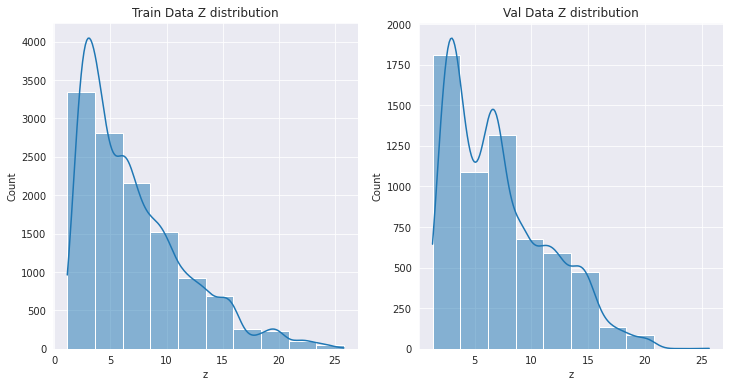

In [67]:
fig, ax = plt.subplots(figsize=(12,6), ncols=2)
sns.histplot(train.z, ax=ax[0], bins=10, kde=True)
sns.histplot(val.z, ax=ax[1], bins=10, kde=True)
ax[0].set_title('Train Data Z distribution')
ax[1].set_title('Val Data Z distribution')

In [71]:
# Look to target skew
print('Skewness', train.z.skew())
print('Kurtosis', train.z.kurt())

Skewness 1.1543622565163445
Kurtosis 0.989661659803434


<AxesSubplot:>

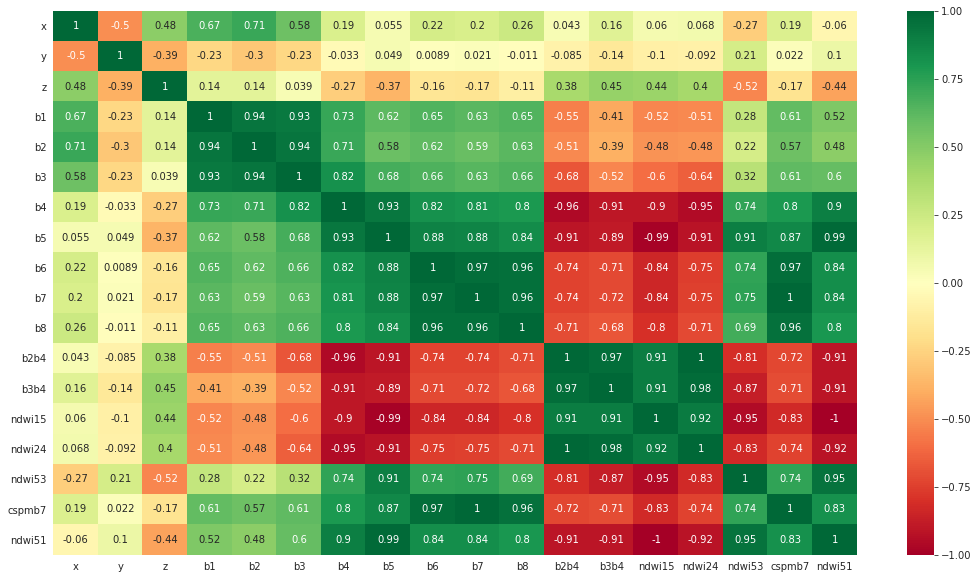

In [100]:
plt.figure(figsize=(18,10))
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn')

In [104]:
corr = train.corr()['z'].sort_values(ascending=False)
corr

z         1.000000
x         0.480880
b3b4      0.449431
ndwi15    0.435397
ndwi24    0.396693
b2b4      0.383636
b2        0.143257
b1        0.142517
b3        0.039081
b8       -0.106783
b6       -0.159671
b7       -0.168323
cspmb7   -0.172311
b4       -0.267342
b5       -0.368677
y        -0.388460
ndwi51   -0.435397
ndwi53   -0.520956
Name: z, dtype: float64

In [171]:
# Ignore x and y correlation ? 
# Select only higher correlation (use absolute value or not?)
best_corr_columns = ['z', 'b3b4', 'ndwi15', 'ndwi24', 'b2b4', 'ndwi51', 'ndwi53', 'cspmb7']

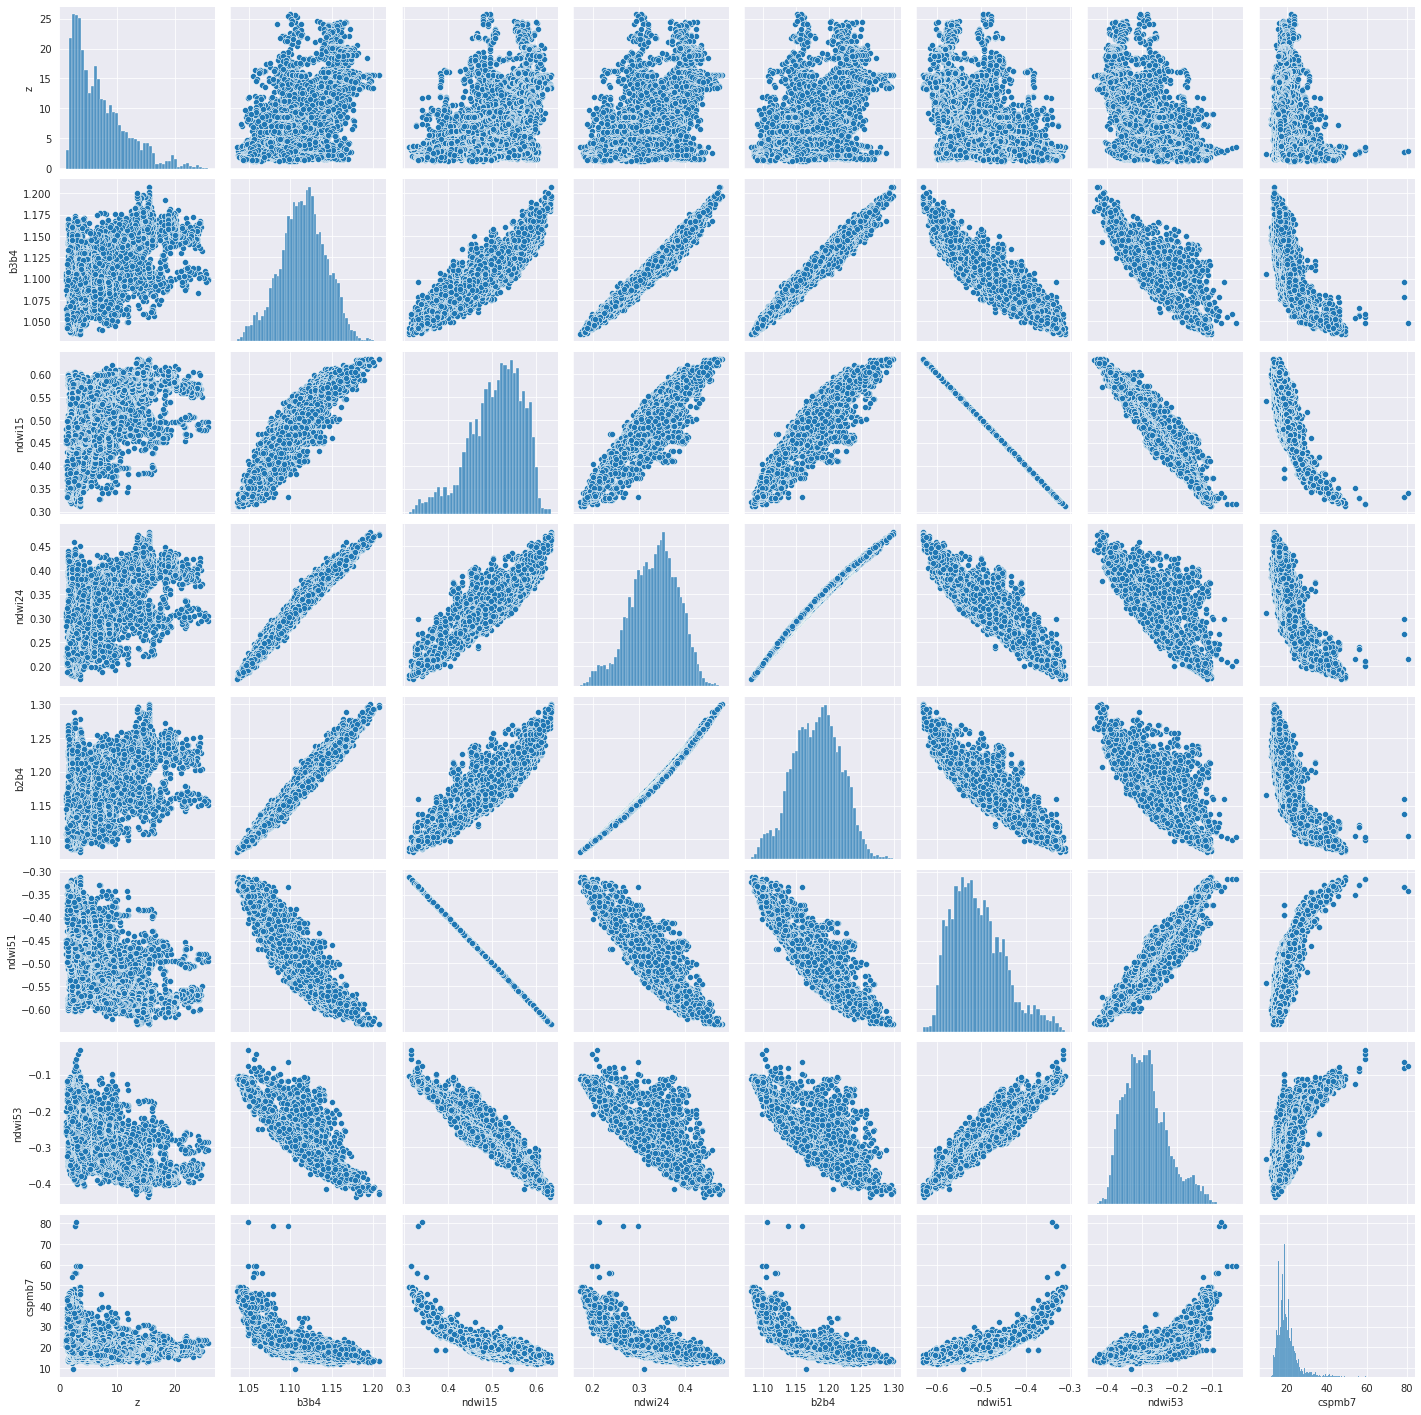

In [172]:
sns.pairplot(train[best_corr_columns])

<AxesSubplot:ylabel='ndwi53'>

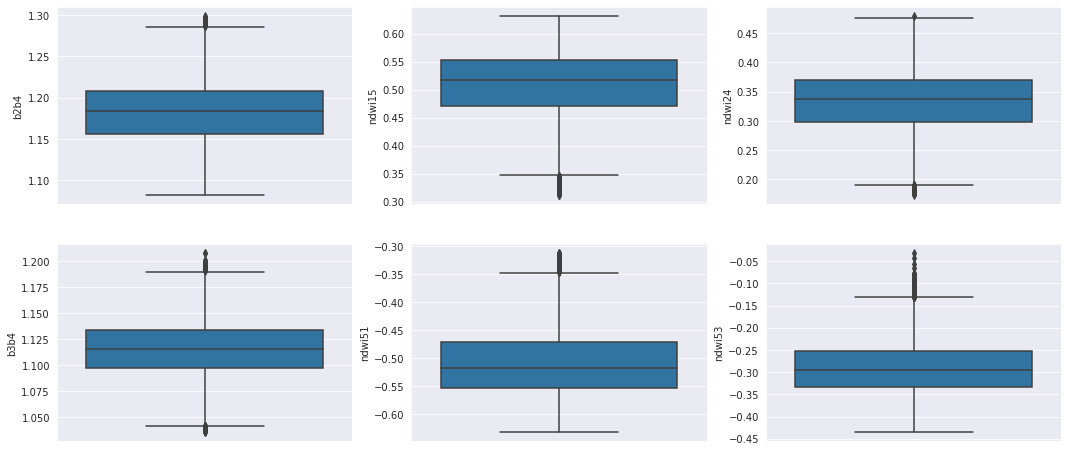

In [208]:
# Some NDWI and Log ratio boxplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
sns.boxplot(y=train.b2b4, ax=ax[0,0])
sns.boxplot(y=train.ndwi15, ax=ax[0,1])
sns.boxplot(y=train.ndwi24, ax=ax[0,2])
sns.boxplot(y=train.b3b4, ax=ax[1,0])
sns.boxplot(y=train.ndwi51, ax=ax[1,1])
sns.boxplot(y=train.ndwi53, ax=ax[1,2])

<AxesSubplot:ylabel='cspmb7'>

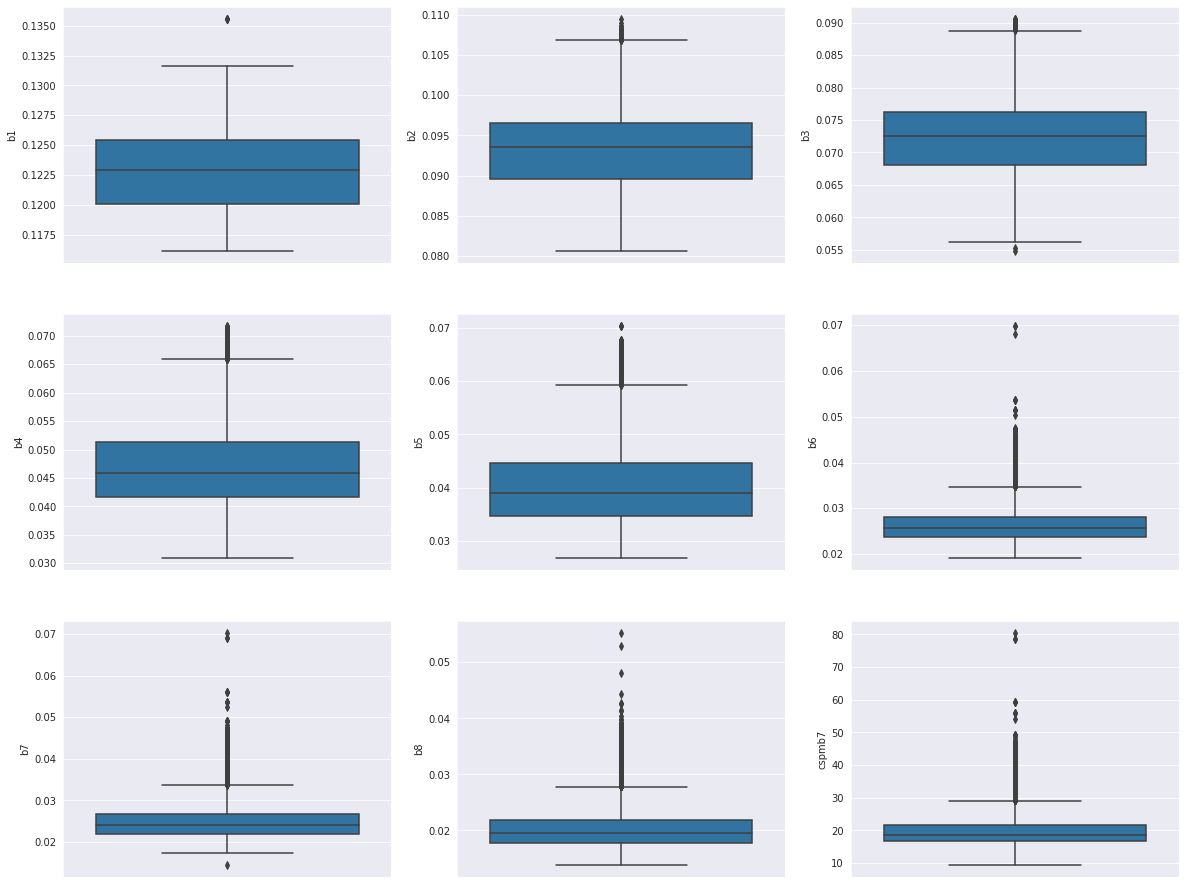

In [233]:
# Some bands  and cspm boxplot
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16))
sns.boxplot(y=train.b1, ax=ax[0,0])
sns.boxplot(y=train.b2, ax=ax[0,1])
sns.boxplot(y=train.b3, ax=ax[0,2])
sns.boxplot(y=train.b4, ax=ax[1,0])
sns.boxplot(y=train.b5, ax=ax[1,1])
sns.boxplot(y=train.b6, ax=ax[1,2])
sns.boxplot(y=train.b7, ax=ax[2,0])
sns.boxplot(y=train.b8, ax=ax[2,1])
sns.boxplot(y=train.cspmb7, ax=ax[2,2])

<AxesSubplot:xlabel='cspmb7', ylabel='Count'>

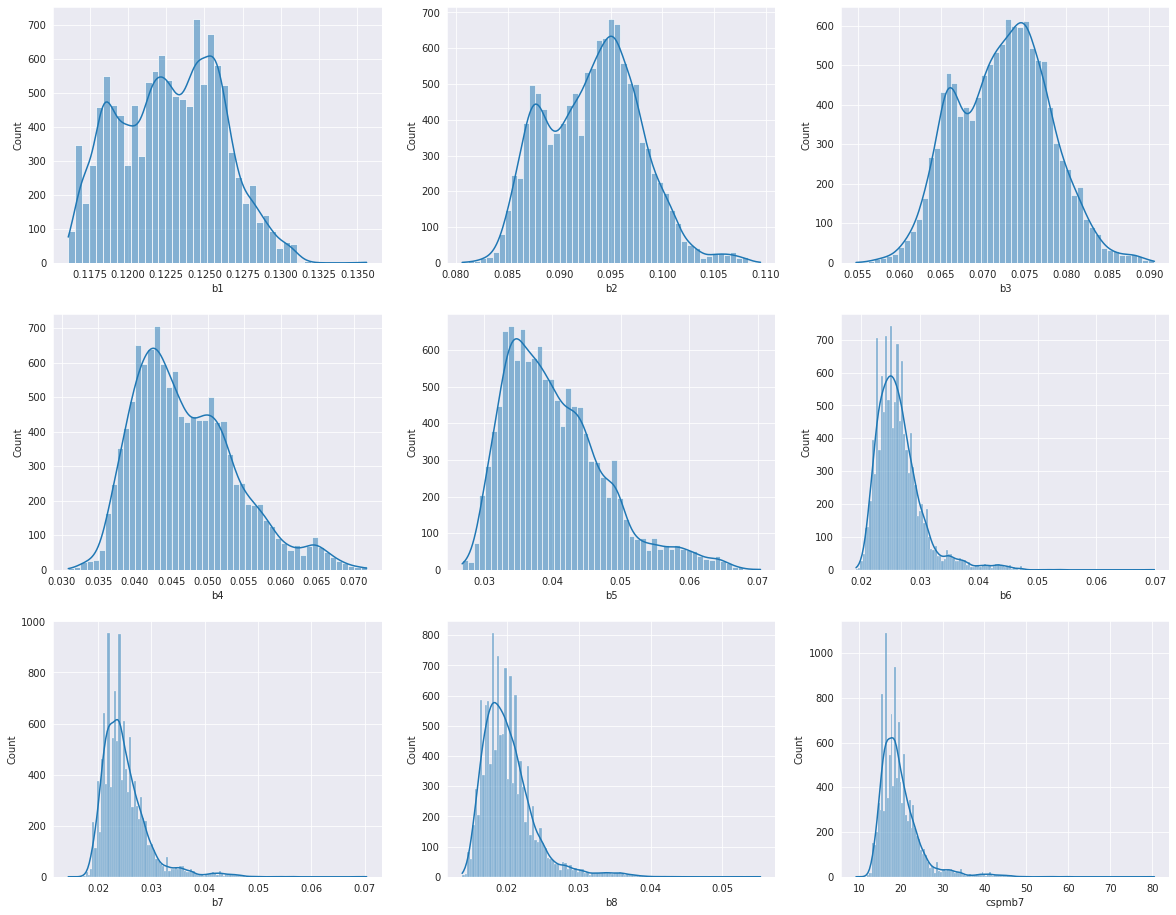

In [321]:
# Some bands  and cspm boxplot
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16))
sns.histplot(train.b1, ax=ax[0,0], kde=True)
sns.histplot(train.b2, ax=ax[0,1], kde=True)
sns.histplot(train.b3, ax=ax[0,2], kde=True)
sns.histplot(train.b4, ax=ax[1,0], kde=True)
sns.histplot(train.b5, ax=ax[1,1], kde=True)
sns.histplot(train.b6, ax=ax[1,2], kde=True)
sns.histplot(train.b7, ax=ax[2,0], kde=True)
sns.histplot(train.b8, ax=ax[2,1], kde=True)
sns.histplot(train.cspmb7, ax=ax[2,2], kde=True)

In [344]:
from scipy.stats import boxcox, skew

In [333]:
only_bands_columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']

skew_data = {}
for column in only_bands_columns:
    skew_data[f'skew_{column}'] = train[column].skew()

skew_df = pd.DataFrame([skew_data])
skew_df
# high positive skew in some columns 
# apply some transformation ? boxcox? log?

,skew_b1,skew_b2,skew_b3,skew_b4,skew_b5,skew_b6,skew_b7,skew_b8
0,0.048064,0.15647,0.060361,0.730726,0.958056,2.005931,2.121439,1.814336


In [392]:
data = boxcox(train['b8'])[0]

In [393]:
skew(data)

0.02247279654201049

In [356]:
# Apply boxcox transf
new_skew_data = {}
for column in only_bands_columns:
    new_skew_data[f'skew_{column}'] = skew(boxcox(train[column])[0])
new_skew_df = pd.DataFrame([new_skew_data])
new_skew_df

,skew_b1,skew_b2,skew_b3,skew_b4,skew_b5,skew_b6,skew_b7,skew_b8
0,-0.000262,0.002307,-0.00637,0.026308,0.04088,0.020594,0.010036,0.022473


In [357]:
only_bands_df_train = train[only_bands_columns].copy()

In [367]:
cox_columns_names = []
for column in only_bands_columns:
    only_bands_df_train[f'cox_{column}'] = boxcox(only_bands_df_train[column])[0]
    cox_columns_names.append(f'cox_{column}')

In [372]:
only_bands_df_train[cox_columns_names]

,cox_b1,cox_b2,cox_b3,cox_b4,cox_b5,cox_b6,cox_b7,cox_b8
0,-2.040070,-3.672015,-1.276651,-24.503807,-30.945099,-1761.076877,-1004.248111,-496.548404
1,-2.040070,-3.637679,-1.276391,-24.924181,-30.945099,-1761.076877,-1004.248111,-500.375240
2,-2.040070,-3.640108,-1.276910,-24.682341,-31.102717,-1657.694223,-1019.716909,-496.548404
3,-2.040070,-3.632832,-1.270203,-25.232735,-31.102717,-1657.694223,-1019.716909,-520.212095
4,-2.042387,-3.628000,-1.274061,-25.108465,-31.023728,-1670.140576,-989.120336,-496.548404
...,...,...,...,...,...,...,...,...
19282,-1.989014,-3.309656,-1.241295,-19.915609,-32.163058,-1873.809582,-1027.582364,-597.633318
19283,-1.989014,-3.337543,-1.240084,-20.077962,-31.584251,-2079.904216,-967.046677,-550.097056
19284,-1.989014,-3.349649,-1.242996,-20.622851,-31.584251,-2079.904216,-967.046677,-520.212095
19285,-1.989014,-3.345603,-1.243727,-20.118931,-31.584251,-2079.904216,-967.046677,-528.489288


In [ ]:
# Some bands  and cspm boxplot
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16))
sns.histplot(only_bands_df_train.cox_b1, ax=ax[0,0], kde=True)
sns.histplot(only_bands_df_train.cox_b2, ax=ax[0,1], kde=True)
sns.histplot(only_bands_df_train.cox_b3, ax=ax[0,2], kde=True)
sns.histplot(only_bands_df_train.cox_b4, ax=ax[1,0], kde=True)
sns.histplot(only_bands_df_train.cox_b5, ax=ax[1,1], kde=True)
sns.histplot(only_bands_df_train.cox_b6, ax=ax[1,2], kde=True)
sns.histplot(only_bands_df_train.cox_b7, ax=ax[2,0], kde=True)
sns.histplot(only_bands_df_train.cox_b8, ax=ax[2,1], kde=True)

In [375]:
only_bands_df_val = val[only_bands_columns].copy()
for column in only_bands_columns:
    only_bands_df_val[f'cox_{column}'] = boxcox(only_bands_df_val[column])[0]

In [394]:
#rf = RandomForestRegressor()
mdl = XGB.XGBRegressor()

In [398]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']
#columns = ['b1', 'b5', 'b6', 'b7']
mdl.fit(train[columns], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [399]:
#p = rf.predict(val[['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']])
p_xgb = mdl.predict(val[columns])

In [400]:
print('Baseline R2 XGBoost:', r2_score(y_val, p_xgb))
print('Baseline MAE XGBoost:', mean_absolute_error(y_val, p_xgb))

Baseline R2 XGBoost: 0.32436173676338176
Baseline MAE XGBoost: 2.5874184390044577


Baseline R2 XGBoost: 0.4164313107890718  
Baseline MAE XGBoost: 2.341030927861902